# ML unsupervised student level

Machine Learning non supervisé : l'objectif ici est de regrouper les étudiants par groupe en fonction de différentes caractéritiques décrites ci-dessous. Une fois que les dofféretns cluster seront formés, nous regarderons si ils sont cohérents avec les niveaux des élèves. Pour ce faire nous analyserons différents modèles de clustering.

Variable Description :
- STG The degree of study time for goal object materials
- SCG The degree of repetition number of user for goal object materials
- STR The degree of study time of user for related objects with goal object
- LPR The exam performance of user for related objects with goal object
- PEG The exam performance of user for goal objects
- UNS The knowledge level of user (Very Low, Low, Middle, High)

In [298]:
# Importation des librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from ydata_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import adjusted_rand_score, homogeneity_score, v_measure_score, silhouette_score

In [299]:
# Chargement du data set et informations générales
data = pd.read_excel("student_level.xls")
data.head(10)

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low
5,0.09,0.15,0.40,0.10,0.66,Middle
6,0.10,0.10,0.43,0.29,0.56,Middle
7,0.15,0.02,0.34,0.40,0.01,very_low
8,0.20,0.14,0.35,0.72,0.25,Low
9,0.00,0.00,0.50,0.20,0.85,High


**Exploration des données**

In [300]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   STG     403 non-null    float64
 1   SCG     403 non-null    float64
 2   STR     403 non-null    float64
 3   LPR     403 non-null    float64
 4   PEG     403 non-null    float64
 5    UNS    403 non-null    object 
dtypes: float64(5), object(1)
memory usage: 19.0+ KB


In [301]:
# Structure des données
data.shape

(403, 6)

In [302]:
# Structure des données
data.describe()

,STG,SCG,STR,LPR,PEG
count,403.000000,403.000000,403.000000,403.000000,403.000000
mean,0.353141,0.355940,0.457655,0.431342,0.456360
std,0.212018,0.215531,0.246684,0.257545,0.266775
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.200000,0.265000,0.250000,0.250000
50%,0.300000,0.300000,0.440000,0.330000,0.400000
75%,0.480000,0.510000,0.680000,0.650000,0.660000
max,0.990000,0.900000,0.950000,0.990000,0.990000


In [303]:
# Structure des données
data.describe(include='object')

,UNS
count,403
unique,5
top,Low
freq,129


In [304]:
# Valeurs manquantes
data.isnull().sum()

STG     0
SCG     0
STR     0
LPR     0
PEG     0
 UNS    0
dtype: int64

In [305]:
print(data.columns)  # Affiche toutes les colonnes du DataFrame

Index(['STG', 'SCG', 'STR', 'LPR', 'PEG', ' UNS'], dtype='object')


**Preparation des données**

In [306]:
# Supprimer les espaces autour des noms de colonnes
data.columns = data.columns.str.strip()

# Vérifier à nouveau les colonnes
print(data.columns)

Index(['STG', 'SCG', 'STR', 'LPR', 'PEG', 'UNS'], dtype='object')


In [307]:
# Remplacer 'very_low' par 'very low' dans la colonne 'UNS'
data['UNS'] = data['UNS'].replace({'very_low': 'verylow', 'Very Low': 'verylow'})

# Convertir toutes les valeurs des colonnes en minuscules
data['UNS'] = data['UNS'].str.lower()

# Vérifier les résultats
print(data[['STG', 'SCG', 'STR', 'LPR', 'PEG', 'UNS']].head())


    STG   SCG   STR   LPR   PEG      UNS
0  0.00  0.00  0.00  0.00  0.00  verylow
1  0.08  0.08  0.10  0.24  0.90     high
2  0.06  0.06  0.05  0.25  0.33      low
3  0.10  0.10  0.15  0.65  0.30   middle
4  0.08  0.08  0.08  0.98  0.24      low


Les variables catégorielles ne peuvent pas être interprétées par les modèles mathématiques, c'est pourquoi il est nécessaire de les encoder. Nous allons le faire pour les données de la variable 'UNS'.

In [308]:
# Encodage des données 
# Dictionnaire de mapping des catégories vers les valeurs numériques
encoding_dict = {
    'verylow': 1,
    'low': 2,
    'middle': 3,
    'high': 4
}

# Appliquer le mapping à la colonne 'UNS'
data['UNS'] = data['UNS'].map(encoding_dict)

# Vérifier les résultats
print(data[['UNS']].head())

   UNS
0    1
1    4
2    2
3    3
4    2


In [309]:
print("Valeurs manquantes dans 'UNS' :")
print(data['UNS'].isna().sum())

Valeurs manquantes dans 'UNS' :
0


**Visualisation des données**

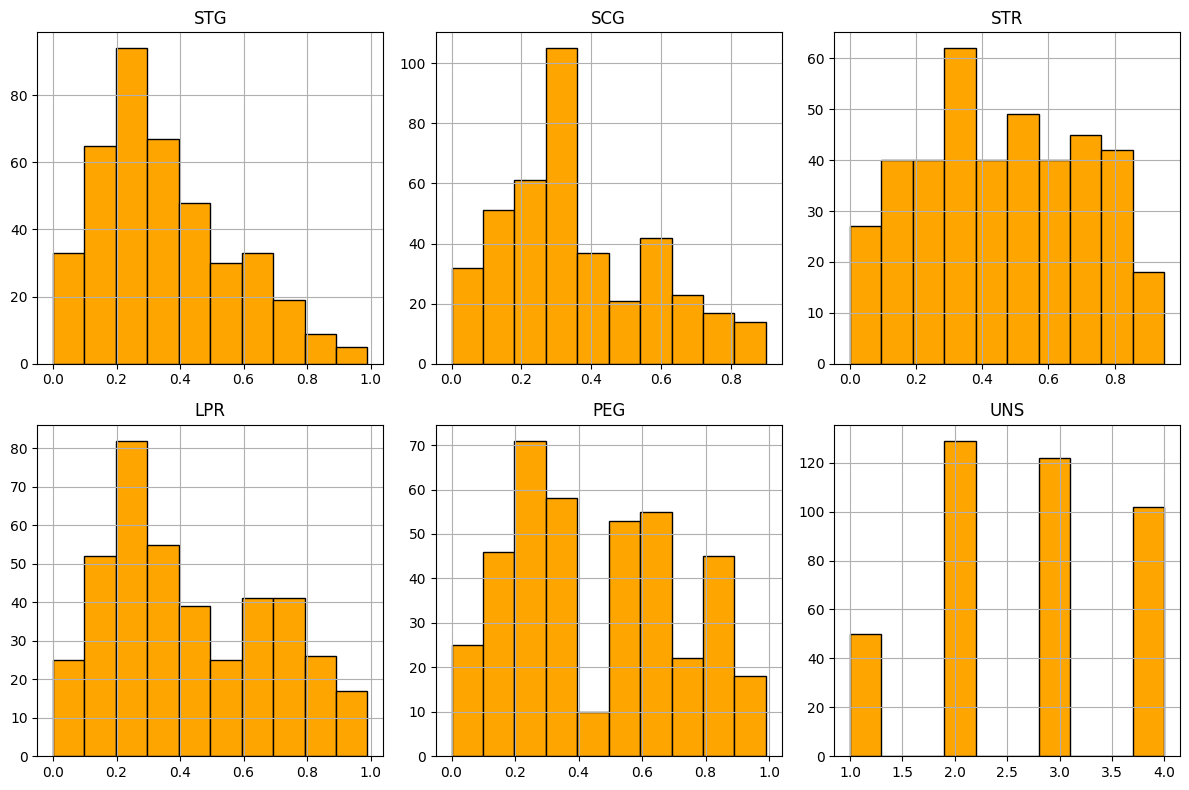

In [310]:
# Histogrammes avec disposition en grille
data[['STG', 'SCG', 'STR', 'LPR', 'PEG', 'UNS']].hist(
    figsize=(12, 8),  
    layout=(2, 3),    
    bins=10,          
    color='orange',  
    edgecolor='black' 
)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


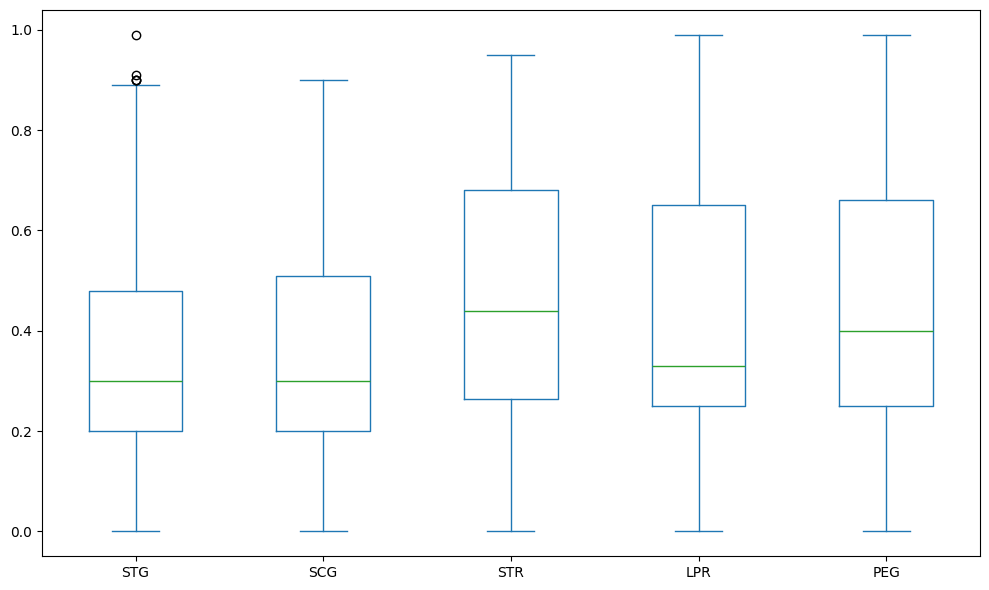

In [311]:
# Box plots avec disposition en grille 
ax = data[['STG', 'SCG', 'STR', 'LPR', 'PEG']].plot(
    kind='box',       
    figsize=(10, 6),  
    layout=(2, 3),    
)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

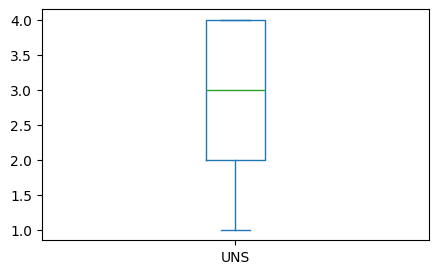

In [312]:
# Un boxplot pour le niveau seul car les échelles sont différentes
ax = data['UNS'].plot(
    kind='box',  
    figsize=(5, 3), 
)

# Ajuster l'espacement entre les sous-graphiques
plt.show()

On remarque qu'il y a très peu d'outliers. L'absence d'outliers signifie que nous n'aurons probablement pas à nous soucier de les traiter, par exemple, en les supprimant ou en les remplaçant. Nous n'aurons pas besoin d'ajuster nos modèles pour compenser l'influence disproportionnée des points extrêmes, ce qui simplifiera nos analyses.

**Analyse des données**

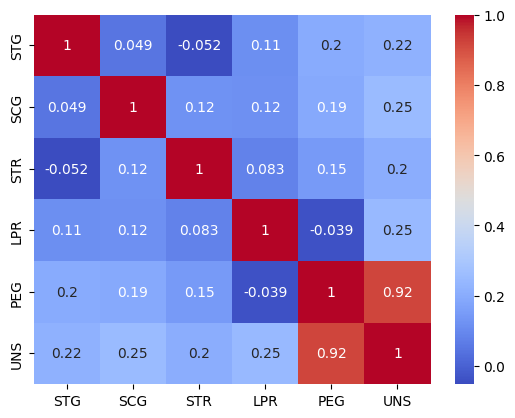

In [313]:
# Mapper les valeurs de 'UNS' en valeurs numériques
#data['UNS'] = data['UNS'].map({'verylow': 1, 'low': 2, 'medium': 3, 'high': 4})

# Calculer la matrice de corrélation sur les données numériques
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.show()

Cette matrice de corrélation nous montre une forte  corrélation positive entre PEG et UNS, et peu de corrélations entre les autres données.

La commande suivante permet de faire une overview générale très rapidement. Elle n'ajoute pas d'information essentielle mais il est intéressant de la conserver en cas d'incohérence entres les données.

In [314]:
# Créer un rapport avec YData Profiling
profile = ProfileReport(data, title="Rapport Exploratoire", explorative=True)

# Afficher le rapport dans un notebook
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**PCA (Principal component analysis)**

On cherche à réduire la dimensionnalité, on choisit de ne retenir qu'un sous-ensemble des composantes principales tout en préservant une grande partie de la variance des données. On choisit donc de prendre 3 composantes principales, tout en sachant qu'ici l'idéal serait de garder les 5 puisqu'elles permettent toutes d'apporter de l'information. Dans le cadre de cet entrainement et dans un soucis de représentation nous garderons 3 dimensions.

In [315]:
# Définir les colonnes de données numériques à normaliser (exemple ici avec des noms de colonnes)
features = ['STG', 'SCG', 'STR', 'LPR', 'PEG']  # Assurez-vous que ces noms de colonnes existent dans votre DataFrame

# Extraire ces colonnes du DataFrame pour en faire la variable X
X = data[features]  

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Vérifier un aperçu des données normalisées
print("Données normalisées :")
print(X_scaled[:5])

Données normalisées :
[[-1.66769329 -1.65351383 -1.85753777 -1.67690584 -1.71277794]
 [-1.28989718 -1.28187552 -1.45165618 -0.74387127  1.66503961]
 [-1.38434621 -1.3747851  -1.65459698 -0.70499483 -0.47424484]
 [-1.19544815 -1.18896594 -1.24871538  0.8500628  -0.58683876]
 [-1.28989718 -1.28187552 -1.5328325   2.13298533 -0.8120266 ]]


Variance expliquée par chaque composante : [0.27933135 0.21365521 0.20691381 0.17060958 0.12949004]
Variance expliquée cumulée : [0.27933135 0.49298657 0.69990038 0.87050996 1.        ]


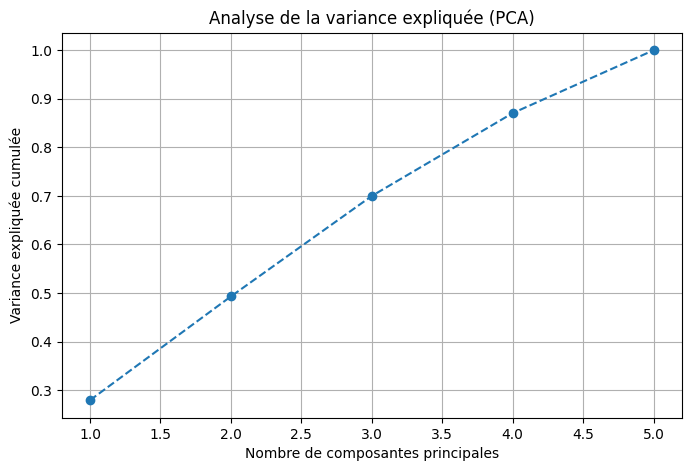

In [316]:
# Appliquer PCA sans fixer le nombre de composantes pour analyser la variance
pca = PCA()
pca.fit(X_scaled)

# Variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Afficher la variance expliquée cumulée
print("Variance expliquée par chaque composante :", explained_variance)
print("Variance expliquée cumulée :", cumulative_variance)


plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Analyse de la variance expliquée (PCA)')
plt.grid()
plt.show()

On voit sur cette courbe que toutes les variables sont importantes, nous en garderons 3 comme expliqué précedemment.

In [317]:
# Trouver le nombre minimal de composantes pour expliquer au moins 69% de la variance
n_components = next(i for i, var in enumerate(cumulative_variance, start=1) if var >= 0.69)
print(f"Nombre optimal de composantes principales : {n_components}")

# Réappliquer PCA avec ce nombre de composantes
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Afficher la variance expliquée par chaque composante principale
print("Variance expliquée par chaque composante principale :", pca.explained_variance_ratio_)

# Afficher la variance cumulative expliquée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Variance cumulative expliquée :", cumulative_variance)


Nombre optimal de composantes principales : 3
Variance expliquée par chaque composante principale : [0.27933135 0.21365521 0.20691381]
Variance cumulative expliquée : [0.27933135 0.49298657 0.69990038]


**Clustering Kmeans**

K-Means est un algorithme de clustering non supervisé qui divise un ensemble de données en **k groupes** basés sur la similarité. Il fonctionne en attribuant chaque point de données au cluster dont le centre (centroïde) est le plus proche, puis en réajustant les centres pour minimiser les écarts.

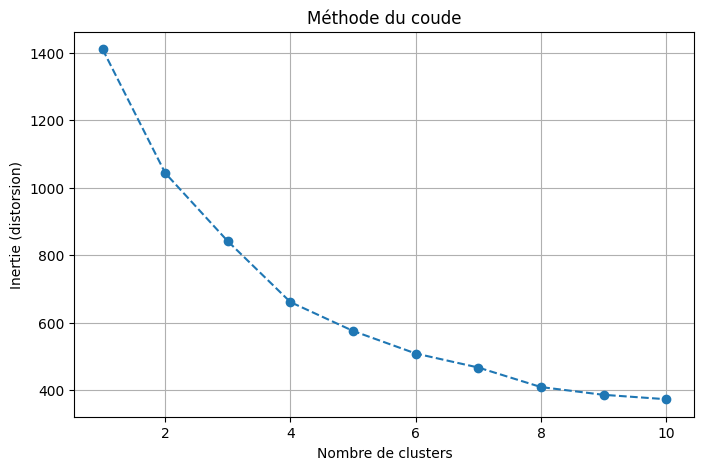

In [318]:
# Méthode du coude pour choisir le nombre optimal de clusters
inertia = []  # Liste pour stocker l'inertie pour chaque nombre de clusters
for k in range(1, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Visualiser la méthode du coude
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie (distorsion)')
plt.title('Méthode du coude')
plt.grid()
plt.show()

La méthode du coude sert à déterminer le nombre optimal de clusters dans un algorithme de clustering (comme K-means) en identifiant le point où l'ajout de clusters supplémentaires n'améliore plus significativement la variance expliquée. Elle permet de visualiser le "coude" dans un graphique de l'inertie en fonction du nombre de clusters. Nous devons confirmer notre choix du nombre de cluster avec une la silhouette index.

La silhouette est une mesure qui évalue la qualité d'un clustering en comparant la cohésion interne (distance moyenne entre un point et les autres points du même cluster) et la séparation entre les clusters (distance moyenne entre un point et les points du cluster le plus proche). 

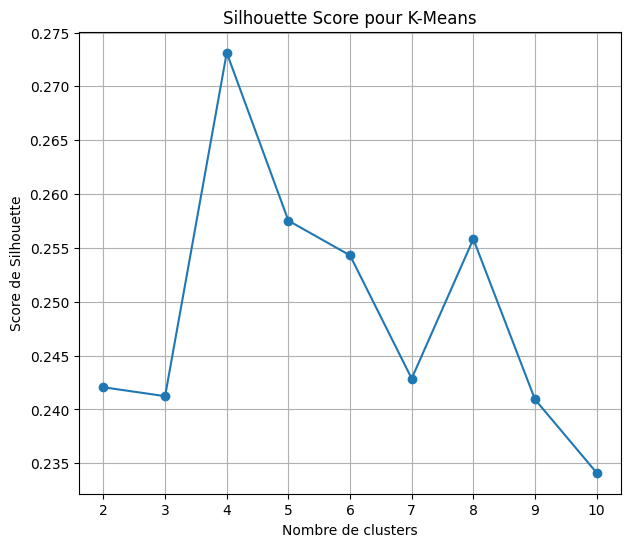

Le nombre optimal de clusters pour K-Means est 4


In [319]:
# Variables
range_n_clusters = list(range(2, 11))

# Initialiser une figure pour le graphe
plt.figure(figsize=(7, 6))

# ---- K-Means ----
kmeans_scores = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters_kmeans = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, clusters_kmeans)
    kmeans_scores.append(silhouette_avg)

# Graphique pour K-Means
plt.plot(range_n_clusters, kmeans_scores, marker='o')
plt.title('Silhouette Score pour K-Means')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Silhouette')
plt.grid(True)

plt.show()

# Affichage du meilleur résultat pour K-Means
best_kmeans_clusters = range_n_clusters[kmeans_scores.index(max(kmeans_scores))]
print(f"Le nombre optimal de clusters pour K-Means est {best_kmeans_clusters}")

Ici on voit que le silhouette score n'est pas très élevé, ce qui montre que les clusters ne sont pas extremement performants, surement à cause du fais que les données ne sont représentées que à 70%.

In [320]:
# Appliquer K-Means avec le nombre optimal de clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Ajouter les clusters au DataFrame original
data['Cluster'] = clusters

# Afficher les premiers résultats
print(data[['Cluster']].head())

   Cluster
0        3
1        3
2        3
3        3
4        1


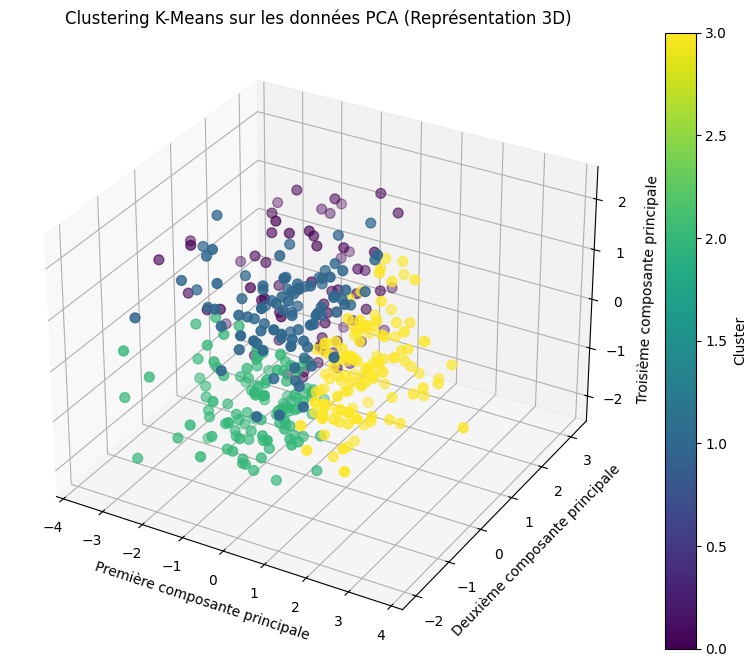

In [321]:
# Créer une figure pour la visualisation 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot des clusters
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', s=50)

# Configurer les axes
ax.set_xlabel('Première composante principale')
ax.set_ylabel('Deuxième composante principale')
ax.set_zlabel('Troisième composante principale')
ax.set_title('Clustering K-Means sur les données PCA (Représentation 3D)')

# Ajouter une légende colorée
plt.colorbar(sc, label='Cluster')

# Afficher la visualisation
plt.show()

**Analyse des clusters Kmeans**

Ici nous allons analyser les cluster formés, et regarder leur cohérence avec les groupes de niveau.

In [322]:
# Moyenne par cluster
stats_by_cluster = data.groupby('Cluster')[['STG', 'SCG', 'STR', 'LPR', 'PEG']].mean()

# Afficher chaque cluster sur une ligne
print("Moyenne par cluster :")
for cluster, stats in stats_by_cluster.iterrows():
    print(f"Cluster {cluster}: STG={stats['STG']:.2f}, SCG={stats['SCG']:.2f}, STR={stats['STR']:.2f}, LPR={stats['LPR']:.2f}, PEG={stats['PEG']:.2f}")

Moyenne par cluster :
Cluster 0: STG=0.65, SCG=0.43, STR=0.34, LPR=0.56, PEG=0.64
Cluster 1: STG=0.27, SCG=0.39, STR=0.53, LPR=0.70, PEG=0.26
Cluster 2: STG=0.30, SCG=0.43, STR=0.64, LPR=0.31, PEG=0.65
Cluster 3: STG=0.30, SCG=0.22, STR=0.29, LPR=0.28, PEG=0.32


In [323]:
# Calcul des statistiques par cluster
stats_by_cluster = data.groupby('Cluster')[['STG', 'SCG', 'STR', 'LPR', 'PEG']].agg(['mean', 'var', 'std', 'median'])

# Afficher les résultats avec une ligne par cluster
print("Statistiques par cluster :")
for cluster in stats_by_cluster.index:
    print(f"Cluster {cluster}:")
    for var in ['STG', 'SCG', 'STR', 'LPR', 'PEG']:
        mean = stats_by_cluster.loc[cluster, (var, 'mean')]
        var_ = stats_by_cluster.loc[cluster, (var, 'var')]
        std = stats_by_cluster.loc[cluster, (var, 'std')]
        median = stats_by_cluster.loc[cluster, (var, 'median')]
        print(f"  {var}: Moyenne={mean:.2f}, Variance={var_:.2f}, Écart-Type={std:.2f}, Médiane={median:.2f}")
    print()

Statistiques par cluster :
Cluster 0:
  STG: Moyenne=0.65, Variance=0.03, Écart-Type=0.18, Médiane=0.68
  SCG: Moyenne=0.43, Variance=0.04, Écart-Type=0.21, Médiane=0.39
  STR: Moyenne=0.34, Variance=0.06, Écart-Type=0.24, Médiane=0.26
  LPR: Moyenne=0.56, Variance=0.08, Écart-Type=0.28, Médiane=0.59
  PEG: Moyenne=0.64, Variance=0.05, Écart-Type=0.21, Médiane=0.65

Cluster 1:
  STG: Moyenne=0.27, Variance=0.02, Écart-Type=0.15, Médiane=0.27
  SCG: Moyenne=0.39, Variance=0.04, Écart-Type=0.21, Médiane=0.33
  STR: Moyenne=0.53, Variance=0.04, Écart-Type=0.21, Médiane=0.56
  LPR: Moyenne=0.70, Variance=0.02, Écart-Type=0.16, Médiane=0.69
  PEG: Moyenne=0.26, Variance=0.02, Écart-Type=0.15, Médiane=0.24

Cluster 2:
  STG: Moyenne=0.30, Variance=0.02, Écart-Type=0.15, Médiane=0.29
  SCG: Moyenne=0.43, Variance=0.05, Écart-Type=0.22, Médiane=0.36
  STR: Moyenne=0.64, Variance=0.03, Écart-Type=0.18, Médiane=0.67
  LPR: Moyenne=0.31, Variance=0.03, Écart-Type=0.18, Médiane=0.29
  PEG: Moyenne

Taille des clusters :
Cluster
3    124
2    118
1     92
0     69
Name: count, dtype: int64


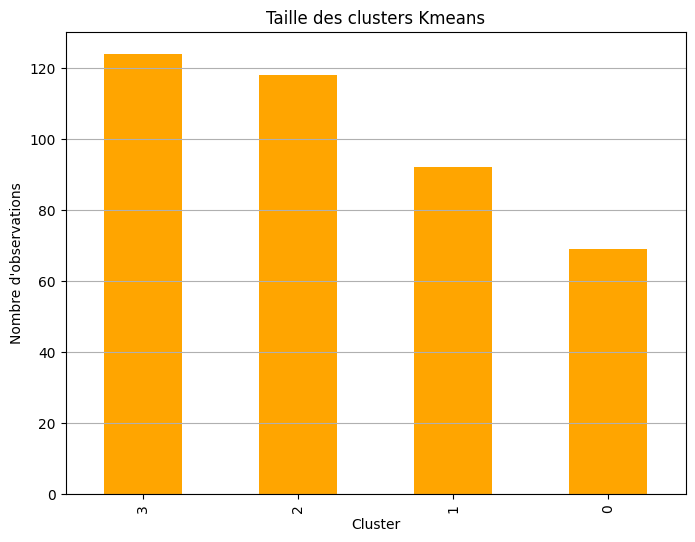

In [324]:
# Afficher la taille de chaque cluster
cluster_sizes = data['Cluster'].value_counts()
print("Taille des clusters :")
print(cluster_sizes)

# Visualisation de la taille des clusters
cluster_sizes.plot(kind='bar', color='orange', figsize=(8, 6))
plt.title("Taille des clusters Kmeans")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'observations")
plt.grid(axis='y')
plt.show()


In [325]:
# Créer une table de contingence
contingency_table = pd.crosstab(data['Cluster'], data['UNS'], rownames=['Cluster'], colnames=['Niveau (UNS)'])
print("Table de contingence :")
print(contingency_table)

# Si UNS est encodé numériquement, on peut comparer avec ARI ou d'autres scores
if data['UNS'].dtype != 'object':
    # Homogénéité
    homogeneity = homogeneity_score(data['UNS'], data['Cluster'])
    print(f"Score d'homogénéité : {homogeneity:.2f}")

    # V-measure
    v_measure = v_measure_score(data['UNS'], data['Cluster'])
    print(f"V-measure : {v_measure:.2f}")

    # Adjusted Rand Index
    ari = adjusted_rand_score(data['UNS'], data['Cluster'])
    print(f"Adjusted Rand Index : {ari:.2f}")
else:
    print("La colonne UNS semble non numérique. Convertissez-la au besoin pour les calculs d'indices.")

Table de contingence :
Niveau (UNS)   1   2   3   4
Cluster                     
0              0   9  21  39
1              8  52  24   8
2              1  18  48  51
3             41  50  29   4
Score d'homogénéité : 0.19
V-measure : 0.18
Adjusted Rand Index : 0.12


La matrice ci-dessus fait sens puisqu'on remarque les individus des clusters 0 et 2 ont des distributions dans les groupes de niveaux similaires, alors que les individus du cluster 3 suivent une répartition dans les groupes de niveaux très diiférentes. Les idividus du cluster 1 sont répartis au dans les groupes de niveaux du milieu.

On suppose donc la répartition des groupes de niveau dans les cluster suivante :
- Cluster 0 -> high
- Cluster 1 -> low
- Cluster 2 -> middle
- Cluster 3 -> very low

Il pourrait être intéressant de voir la contribution de la variable PEG dans notre PCA puisqu'elle présentait une forte corrélation avec le niveau des étudiants.

**Clustering PAM**

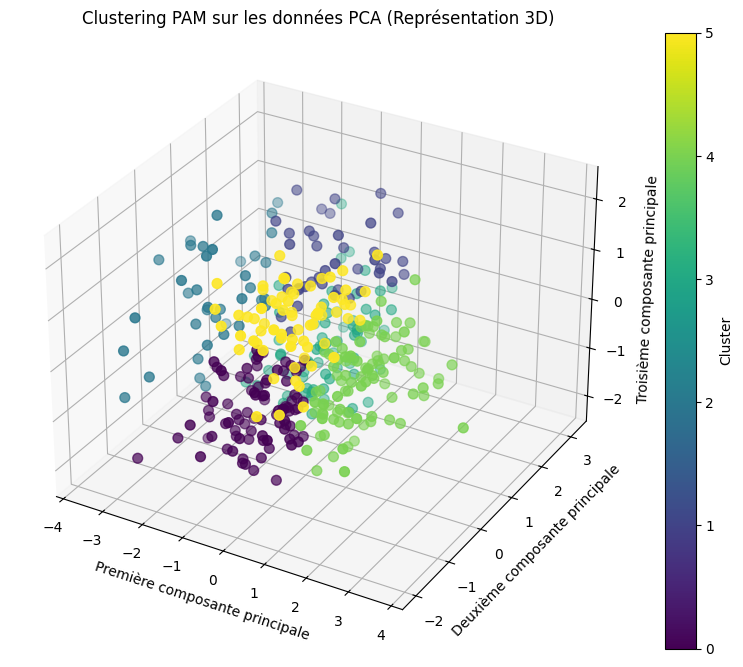

In [326]:
# Appliquer PAM (K-Medoids)
kmedoids = KMedoids(n_clusters=6, random_state=42)
clusters_pam = kmedoids.fit_predict(X_pca)

# Ajouter les clusters PAM au DataFrame
data['Cluster_PAM'] = clusters_pam

# Créer une figure pour la visualisation 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot des clusters PAM
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters_pam, cmap='viridis', s=50)

# Configurer les axes
ax.set_xlabel('Première composante principale')
ax.set_ylabel('Deuxième composante principale')
ax.set_zlabel('Troisième composante principale')
ax.set_title('Clustering PAM sur les données PCA (Représentation 3D)')

# Ajouter une légende colorée
plt.colorbar(sc, label='Cluster')

# Afficher la visualisation
plt.show()


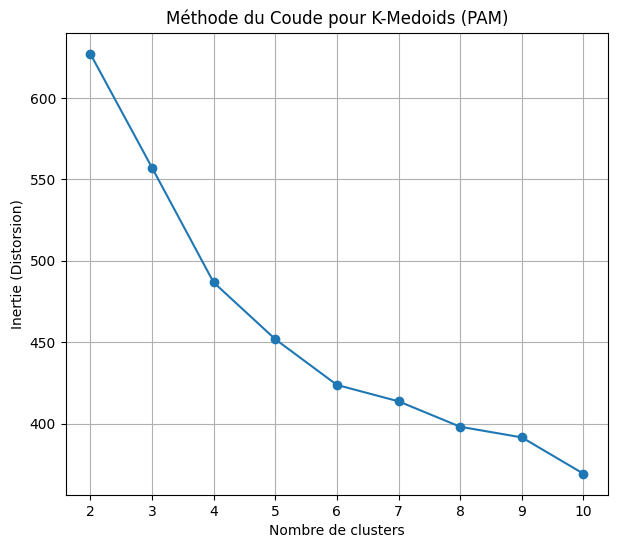

Le nombre optimal de clusters pour K-Medoids (PAM) selon la méthode du coude est 10


In [327]:
# Variables
range_n_clusters = list(range(2, 11))

# Calcul des distorsions (inertie) pour chaque nombre de clusters
inertia_scores = []
for n_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
    kmedoids.fit(X_pca) 
    inertia_scores.append(kmedoids.inertia_)

# Tracer la courbe de la méthode du coude
plt.figure(figsize=(7, 6))
plt.plot(range_n_clusters, inertia_scores, marker='o')
plt.title('Méthode du Coude pour K-Medoids (PAM)')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie (Distorsion)')
plt.grid(True)
plt.show()

# Affichage du nombre optimal de clusters (le coude)
optimal_clusters = range_n_clusters[inertia_scores.index(min(inertia_scores))]
print(f"Le nombre optimal de clusters pour K-Medoids (PAM) selon la méthode du coude est {optimal_clusters}")

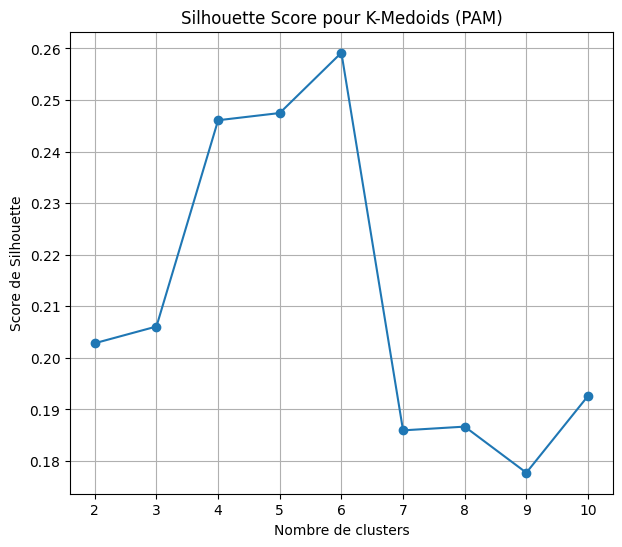

Le nombre optimal de clusters pour K-Medoids (PAM) est 6


In [328]:
# Variables
range_n_clusters = list(range(2, 11))

# Initialiser une figure pour le graphe
plt.figure(figsize=(7, 6))

# ---- K-Medoids (PAM) ----
kmedoids_scores = []
for n_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
    clusters_kmedoids = kmedoids.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, clusters_kmedoids)
    kmedoids_scores.append(silhouette_avg)

# Graphique pour K-Medoids
plt.plot(range_n_clusters, kmedoids_scores, marker='o')
plt.title('Silhouette Score pour K-Medoids (PAM)')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de Silhouette')
plt.grid(True)

plt.show()

# Affichage du meilleur résultat pour K-Medoids
best_kmedoids_clusters = range_n_clusters[kmedoids_scores.index(max(kmedoids_scores))]
print(f"Le nombre optimal de clusters pour K-Medoids (PAM) est {best_kmedoids_clusters}")

Nous garderons 6 clusters.

**Analyse PAM**

In [329]:
# Moyenne par cluster
stats_by_cluster = data.groupby('Cluster_PAM')[['STG', 'SCG', 'STR', 'LPR', 'PEG']].mean()

# Afficher chaque cluster sur une ligne
print("Moyenne par cluster :")
for cluster, stats in stats_by_cluster.iterrows():
    print(f"Cluster {cluster}: STG={stats['STG']:.2f}, SCG={stats['SCG']:.2f}, STR={stats['STR']:.2f}, LPR={stats['LPR']:.2f}, PEG={stats['PEG']:.2f}")

Moyenne par cluster :
Cluster 0: STG=0.27, SCG=0.43, STR=0.66, LPR=0.29, PEG=0.61
Cluster 1: STG=0.52, SCG=0.33, STR=0.28, LPR=0.72, PEG=0.37
Cluster 2: STG=0.48, SCG=0.61, STR=0.65, LPR=0.77, PEG=0.70
Cluster 3: STG=0.57, SCG=0.36, STR=0.34, LPR=0.29, PEG=0.63
Cluster 4: STG=0.25, SCG=0.21, STR=0.30, LPR=0.25, PEG=0.30
Cluster 5: STG=0.21, SCG=0.34, STR=0.53, LPR=0.67, PEG=0.22


In [330]:
# Calcul des statistiques par cluster
stats_by_cluster = data.groupby('Cluster_PAM')[['STG', 'SCG', 'STR', 'LPR', 'PEG']].agg(['mean', 'var', 'std', 'median'])

# Afficher les résultats avec une ligne par cluster
print("Statistiques par cluster :")
for cluster in stats_by_cluster.index:
    print(f"Cluster {cluster}:")
    for var in ['STG', 'SCG', 'STR', 'LPR', 'PEG']:
        mean = stats_by_cluster.loc[cluster, (var, 'mean')]
        var_ = stats_by_cluster.loc[cluster, (var, 'var')]
        std = stats_by_cluster.loc[cluster, (var, 'std')]
        median = stats_by_cluster.loc[cluster, (var, 'median')]
        print(f"  {var}: Moyenne={mean:.2f}, Variance={var_:.2f}, Écart-Type={std:.2f}, Médiane={median:.2f}")
    print()

Statistiques par cluster :
Cluster 0:
  STG: Moyenne=0.27, Variance=0.02, Écart-Type=0.13, Médiane=0.26
  SCG: Moyenne=0.43, Variance=0.04, Écart-Type=0.21, Médiane=0.37
  STR: Moyenne=0.66, Variance=0.03, Écart-Type=0.17, Médiane=0.70
  LPR: Moyenne=0.29, Variance=0.02, Écart-Type=0.14, Médiane=0.29
  PEG: Moyenne=0.61, Variance=0.05, Écart-Type=0.21, Médiane=0.60

Cluster 1:
  STG: Moyenne=0.52, Variance=0.03, Écart-Type=0.17, Médiane=0.52
  SCG: Moyenne=0.33, Variance=0.04, Écart-Type=0.19, Médiane=0.29
  STR: Moyenne=0.28, Variance=0.03, Écart-Type=0.16, Médiane=0.25
  LPR: Moyenne=0.72, Variance=0.02, Écart-Type=0.15, Médiane=0.70
  PEG: Moyenne=0.37, Variance=0.05, Écart-Type=0.23, Médiane=0.26

Cluster 2:
  STG: Moyenne=0.48, Variance=0.06, Écart-Type=0.24, Médiane=0.45
  SCG: Moyenne=0.61, Variance=0.06, Écart-Type=0.24, Médiane=0.67
  STR: Moyenne=0.65, Variance=0.04, Écart-Type=0.19, Médiane=0.69
  LPR: Moyenne=0.77, Variance=0.03, Écart-Type=0.17, Médiane=0.81
  PEG: Moyenne

Taille des clusters :
Cluster_PAM
4    98
0    91
5    68
3    67
1    41
2    38
Name: count, dtype: int64


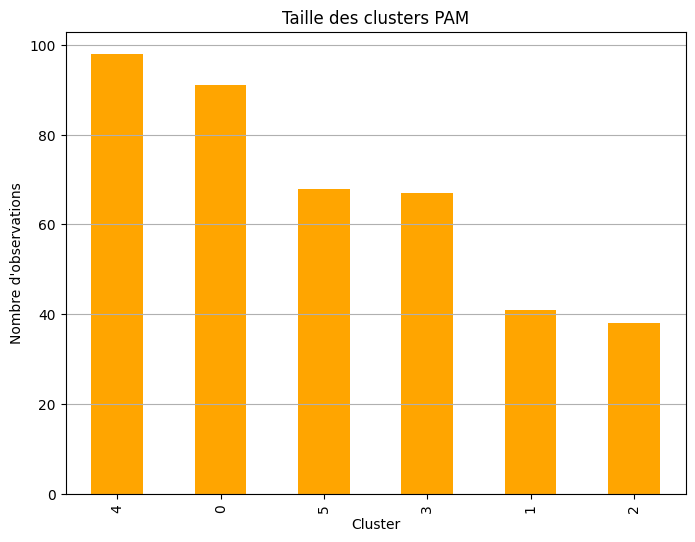

In [331]:
# Afficher la taille de chaque cluster
cluster_sizes = data['Cluster_PAM'].value_counts()
print("Taille des clusters :")
print(cluster_sizes)

# Visualisation de la taille des clusters
cluster_sizes.plot(kind='bar', color='orange', figsize=(8, 6))
plt.title("Taille des clusters PAM")
plt.xlabel("Cluster")
plt.ylabel("Nombre d'observations")
plt.grid(axis='y')
plt.show()


In [332]:
# Créer une table de contingence
contingency_table = pd.crosstab(data['Cluster_PAM'], data['UNS'], rownames=['Cluster'], colnames=['Niveau (UNS)'])
print("Table de contingence :")
print(contingency_table)

# Si UNS est encodé numériquement, on peut comparer avec ARI ou d'autres scores
if data['UNS'].dtype != 'object': 
    # Homogénéité
    homogeneity = homogeneity_score(data['UNS'], data['Cluster_PAM'])
    print(f"Score d'homogénéité : {homogeneity:.2f}")

    # V-measure
    v_measure = v_measure_score(data['UNS'], data['Cluster_PAM'])
    print(f"V-measure : {v_measure:.2f}")

    # Adjusted Rand Index
    ari = adjusted_rand_score(data['UNS'], data['Cluster_PAM'])
    print(f"Adjusted Rand Index : {ari:.2f}")
else:
    print("La colonne UNS semble non numérique. Convertissez-la au besoin pour les calculs d'indices.")

Table de contingence :
Niveau (UNS)   1   2   3   4
Cluster                     
0              1  19  40  31
1              2  20   8  11
2              0   0   6  32
3              0  14  28  25
4             37  36  23   2
5             10  40  17   1
Score d'homogénéité : 0.22
V-measure : 0.19
Adjusted Rand Index : 0.10


La matrice ci-dessus fait sens puisqu'on remarque les individus des différents clusters ont des distributions dans les groupes de niveaux différentes.

On suppose donc la répartition des groupes de niveau dans ou entre les clusters suivante :
- Cluster 0 -> middle
- Cluster 1 -> low/middle
- Cluster 2 -> high
- Cluster 3 -> middle/high
- Cluster 4 -> very low
- Cluster 5 -> low